Сгенерируем тестовые сигналы:

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

fs = 8000  
f0 = 200   # ЧОТ
duration = 0.03 
t = np.linspace(0, duration, int(fs * duration), endpoint=False)

# Простой синус 
sine = 0.5 * np.sin(2 * np.pi * f0 * t)

# Гармонический сигнал с обертонами
harmonic_signal = sum(0.5 / h * np.sin(2 * np.pi * f0 * h * t) for h in range(1, 4))

# Сигнал с мощными верхними гармониками и слабой основной 
missing_fundamental = sum(1.0 / h * np.sin(2 * np.pi * f0 * h * t) for h in range(2, 6))

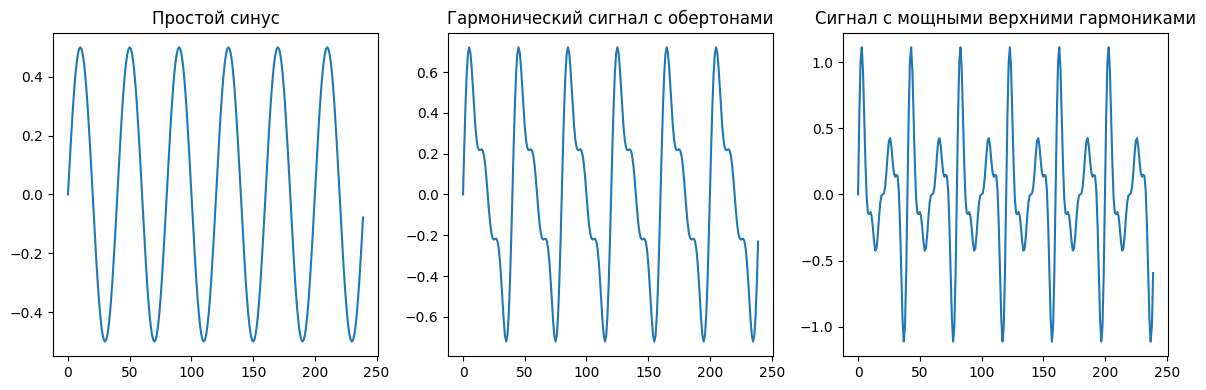

In [100]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(sine)
plt.title('Простой синус')

plt.subplot(1, 3, 2)
plt.plot(harmonic_signal)
plt.title('Гармонический сигнал с обертонами')

plt.subplot(1, 3, 3)
plt.plot(missing_fundamental)
plt.title('Сигнал с мощными верхними гармониками')

plt.tight_layout()
plt.show()

<h2>Вычисление ЧОТ с помощью параметра частоты перехода через 0 (zero-crossing rate)</h2>

In [101]:
def zero_crossings(signal):    
    zero_crossings = np.where(np.diff(np.sign(signal)))[0]
    return zero_crossings

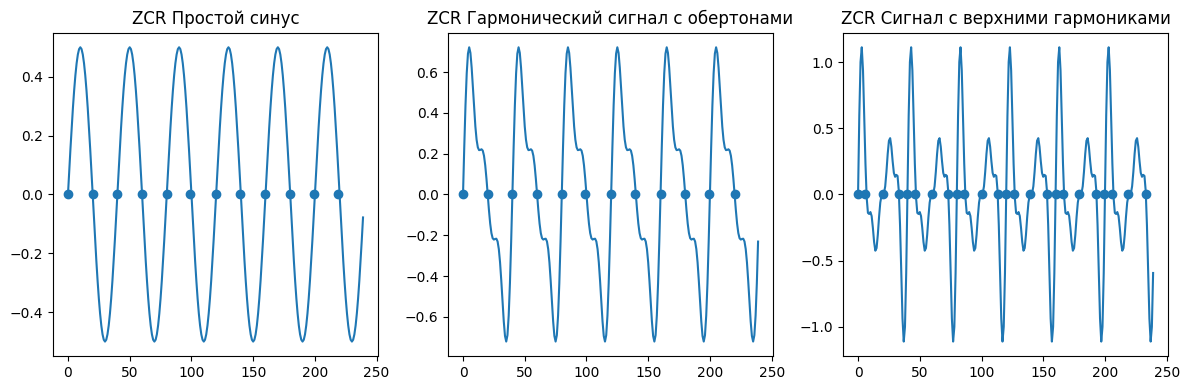

In [102]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(sine)
plt.scatter(zero_crossings(sine), np.zeros(len(zero_crossings(sine))))
plt.title('ZCR Простой синус')

plt.subplot(1, 3, 2)
plt.plot(harmonic_signal)
plt.scatter(zero_crossings(harmonic_signal), np.zeros(len(zero_crossings(harmonic_signal))))
plt.title('ZCR Гармонический сигнал с обертонами')

plt.subplot(1, 3, 3)
plt.plot(missing_fundamental)
plt.scatter(zero_crossings(missing_fundamental), np.zeros(len(zero_crossings(missing_fundamental))))
plt.title('ZCR Сигнал с верхними гармониками')

plt.tight_layout()
plt.show()

In [103]:
def zero_crossing_rate(signal):
    """Простой подсчет f0 по ZCR"""
    
    zero_crossings = np.where(np.diff(np.sign(signal)))[0]

    zcr_per_second = len(zero_crossings) * fs / len(signal)

    estimated_f0 = zcr_per_second / 2.0

    return estimated_f0

In [104]:
print(zero_crossing_rate(sine))
print(zero_crossing_rate(harmonic_signal))
print(zero_crossing_rate(missing_fundamental))

200.0
200.0
400.0


In [105]:
from scipy.signal import butter, filtfilt

def zero_crossing_rate_with_lpf(signal, fs, cutoff_freq=500):
    """Подсчет f0 по ZCR с предварительной фильтрацией"""

    nyquist = fs / 2
    normalized_cutoff = cutoff_freq / nyquist
    order = 4
    b, a = butter(order, normalized_cutoff, btype='low')

    filtered = filtfilt(b, a, signal)
    
    zero_crossings = np.where(np.diff(np.sign(filtered)))[0]

    zcr_per_second = len(zero_crossings) * fs / len(signal)

    estimated_f0 = zcr_per_second / 2.0

    return estimated_f0

In [106]:
print(zero_crossing_rate_with_lpf(sine, fs))
print(zero_crossing_rate_with_lpf(harmonic_signal, fs))
print(zero_crossing_rate_with_lpf(missing_fundamental, fs))

200.0
200.0
383.3333333333333


In [ ]:
from collections import Counter

def find_repeating_sequences(intervals, min_sequence_len=8):
    """
    Поиск повторяющихся последовательностей интервалов
    """
    patterns = {}
    
    # Ищем последовательности разной длины
    for seq_len in range(2, len(intervals) // 2):
        for i in range(len(intervals) - seq_len * 2 + 1):
            seq1 = intervals[i:i+seq_len]
            seq2 = intervals[i+seq_len:i+2*seq_len]
            
            # Проверяем, похожи ли последовательности (с допуском)
            if are_sequences_similar(seq1, seq2, tolerance=2):
                seq_tuple = tuple(seq1)
                patterns[seq_tuple] = patterns.get(seq_tuple, 0) + 1
    
    return patterns

    
def are_sequences_similar(seq1, seq2, tolerance=2):
    """
    Проверка, похожи ли две последовательности интервалов.
    tolerance - допустимое отклонение в отсчётах
    """
    if len(seq1) != len(seq2):
        return False
    
    # Нормализуем последовательности
    seq1_norm = seq1 / np.mean(seq1) if np.mean(seq1) > 0 else seq1
    seq2_norm = seq2 / np.mean(seq2) if np.mean(seq2) > 0 else seq2
    
    # Проверяем корреляцию
    correlation = np.corrcoef(seq1_norm, seq2_norm)[0, 1]
    
    # И максимальное отклонение
    max_diff = np.max(np.abs(np.array(seq1) - np.array(seq2)))
    
    return correlation > 0.9 and max_diff <= tolerance


def estimate_f0_from_patterns(patterns, intervals, fs):
    """
    Оценка f0 на основе найденных паттернов.
    """
    f0_candidates = []
    
    # Для каждого найденного паттерна
    for pattern, count in patterns.items():
        # Паттерн представляет собой последовательность интервалов
        # Сумма интервалов в паттерне = период сигнала
        pattern_sum = sum(pattern)
        
        if pattern_sum > 0:
            # Частота = fs / период
            f0_candidate = fs / pattern_sum
            f0_candidates.append(f0_candidate)
    
    return f0_candidates


def zero_crossing_rate_with_pattern_search(signal, fs, cutoff_freq=500):
    """ Ищем паттерны в zcr"""    
    zero_crossings = np.where(np.diff(np.sign(signal)))[0]
    zero_crossings_diffs = np.diff(zero_crossings)
    print("diffs: ", zero_crossings_diffs)

    patterns = find_repeating_sequences(zero_crossings_diffs)
    print("patterns", patterns)

    f0_candidates = estimate_f0_from_patterns(patterns, zero_crossings_diffs, fs)

    valid_candidates = [f for f in f0_candidates if 40 <= f <= 500]

    print("candidates:", valid_candidates)
    
    if valid_candidates:
        # Выбираем наиболее частого кандидата
        estimated_f0 = Counter(valid_candidates).most_common(1)[0][0]
    else:
        estimated_f0 = 0

    return estimated_f0

In [134]:
print("estimated f0: ", zero_crossing_rate_with_pattern_search(sine, fs), "\n")
print("estimated f0: ", zero_crossing_rate_with_pattern_search(harmonic_signal, fs), "\n")
print("estimated f0: ", zero_crossing_rate_with_pattern_search(missing_fundamental, fs), "\n")

diffs:  [20 20 20 20 19 21 19 21 20 19 20]
patterns {(20, 19): 1, (19, 21): 1, (21, 19): 1, (21, 19, 21): 1}
candidates: [205.12820512820514, 200.0, 200.0, 131.14754098360655]
estimated f0:  200.0 

diffs:  [20 20 20 20 19 21 19 21 20 19 21]
patterns {(20, 19): 1, (19, 21): 1, (21, 19): 1}
candidates: [205.12820512820514, 200.0, 200.0]
estimated f0:  200.0 

diffs:  [ 6 14 13  7  6 14 13  7  6 14 13  7  6 13 14  7  6 13 14  6  7 13 14]
patterns {(6, 14, 13, 7): 3, (14, 13, 7, 6): 3, (13, 7, 6, 14): 2, (7, 6, 14, 13): 2, (13, 7, 6, 13): 1, (7, 6, 13, 14): 2, (6, 13, 14, 7): 1, (13, 14, 7, 6): 1, (14, 7, 6, 13): 1, (6, 14, 13, 7, 6, 14, 13, 7): 2, (14, 13, 7, 6, 14, 13, 7, 6): 2, (13, 7, 6, 14, 13, 7, 6, 14): 1, (7, 6, 14, 13, 7, 6, 14, 13): 1, (13, 7, 6, 14, 13, 7, 6, 13): 1, (7, 6, 14, 13, 7, 6, 13, 14): 1}
candidates: [200.0, 200.0, 200.0, 200.0, 205.12820512820514, 200.0, 200.0, 200.0, 200.0, 100.0, 100.0, 100.0, 100.0, 101.26582278481013, 100.0]
estimated f0:  200.0 



c:\Users\annao\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\annao\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\annao\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


<h2>Вычисление ЧОТ по пикам в сигнале</h2>

In [135]:
def get_peaks(signal, fs):
    peaks, _ = find_peaks(signal, distance=fs//1000)  # минимальное расстояние
    return peaks

In [136]:
def peak_rate(signal, fs):
    """Частота пиков как оценка f0."""

    peaks, _ = find_peaks(signal, distance=fs//1000)  # минимальное расстояние

    peaks_per_second = len(peaks) * fs / len(signal)
    
    return peaks_per_second

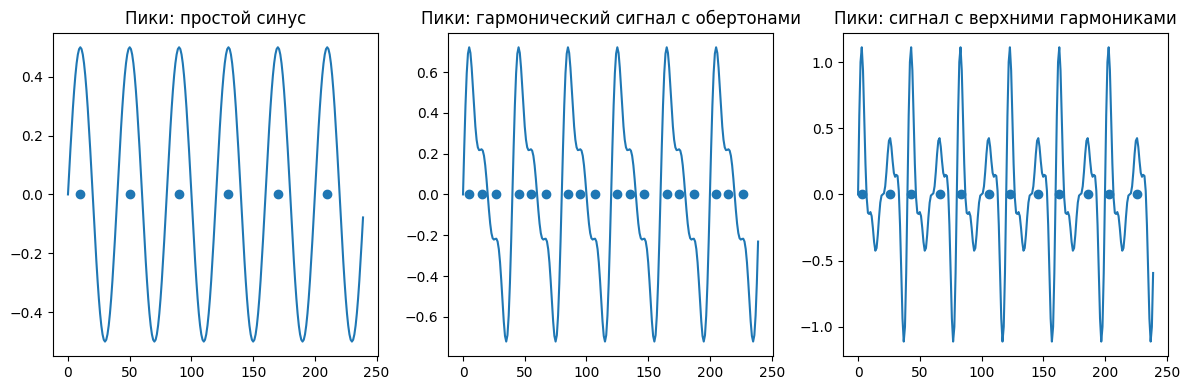

In [137]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(sine)
plt.scatter(get_peaks(sine, fs), np.zeros(len(get_peaks(sine, fs))))
plt.title('Пики: простой синус')

plt.subplot(1, 3, 2)
plt.plot(harmonic_signal)
plt.scatter(get_peaks(harmonic_signal, fs), np.zeros(len(get_peaks(harmonic_signal, fs))))
plt.title('Пики: гармонический сигнал с обертонами')

plt.subplot(1, 3, 3)
plt.plot(missing_fundamental)
plt.scatter(get_peaks(missing_fundamental, fs), np.zeros(len(get_peaks(missing_fundamental, fs))))
plt.title('Пики: сигнал с верхними гармониками')

plt.tight_layout()
plt.show()

Задание. Аналогично методу ZCR, вычислите ЧОТ, находя паттерны в распределении пиков сигнала.

<h2>Вычисление ЧОТ с помощью производной сигнала</h2>

In [138]:
def get_derivatives(signal):
    return np.diff(signal)

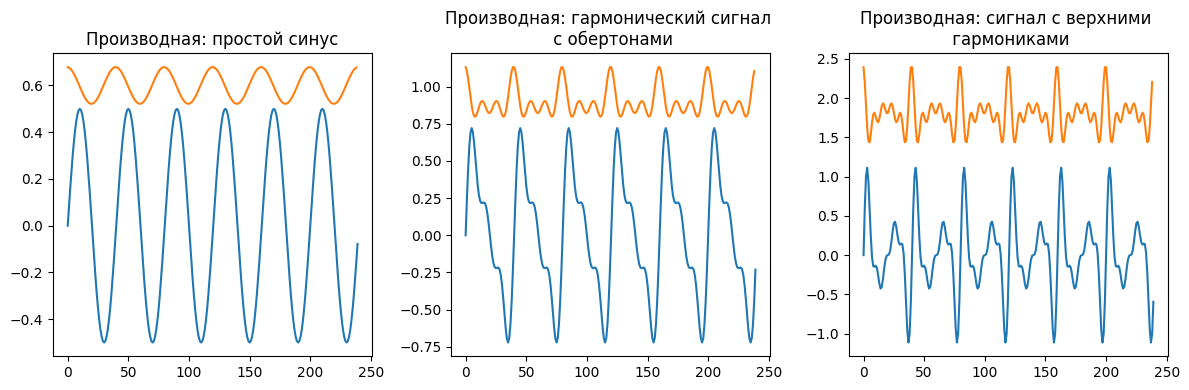

In [144]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(sine)
plt.plot(get_derivatives(sine) + 0.6)
plt.title('Производная: простой синус')

plt.subplot(1, 3, 2)
plt.plot(harmonic_signal)
plt.plot(get_derivatives(harmonic_signal) + 0.9)
plt.title('Производная: гармонический сигнал \n с обертонами')

plt.subplot(1, 3, 3)
plt.plot(missing_fundamental)
plt.plot(get_derivatives(missing_fundamental) + 1.8)
plt.title('Производная: сигнал с верхними \n гармониками')

plt.tight_layout()
plt.show()

In [140]:
print("estimated f0: ", zero_crossing_rate_with_pattern_search(get_derivatives(sine), fs), "\n")
print("estimated f0: ", zero_crossing_rate_with_pattern_search(get_derivatives(harmonic_signal), fs), "\n")
print("estimated f0: ", zero_crossing_rate_with_pattern_search(get_derivatives(missing_fundamental), fs), "\n")

diffs:  [20 20 20 20 20 20 20 20 20 20 20]
patterns {}
candidates: []
estimated f0:  0 

diffs:  [ 8  2 10  2  8 10  8  2 10  2  8 10  8  2 10  2  8 10  8  2 10  2  8 10
  8  2 10  2  8 10  8  2 10  2  8]
patterns {(8, 2): 6, (2, 10): 6, (8, 2, 10, 2, 8, 10): 4, (2, 10, 2, 8, 10, 8): 4, (10, 2, 8, 10, 8, 2): 4, (2, 8, 10, 8, 2, 10): 4, (8, 10, 8, 2, 10, 2): 4, (10, 8, 2, 10, 2, 8): 4, (8, 2, 10, 2, 8, 10, 8, 2, 10, 2, 8, 10): 2, (2, 10, 2, 8, 10, 8, 2, 10, 2, 8, 10, 8): 2, (10, 2, 8, 10, 8, 2, 10, 2, 8, 10, 8, 2): 2, (2, 8, 10, 8, 2, 10, 2, 8, 10, 8, 2, 10): 2, (8, 10, 8, 2, 10, 2, 8, 10, 8, 2, 10, 2): 2, (10, 8, 2, 10, 2, 8, 10, 8, 2, 10, 2, 8): 2}
candidates: [200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
estimated f0:  200.0 

diffs:  [ 6  1  4 12  4  1  6  6  6  1  4 12  4  1  6  6  6  1  4 12  4  1  6  6
  6  1  4 12  4  1  6  6  6  1  4 12  4  1  6  6  6  1  4 12  4  1  6]
patterns {(6, 1, 4, 12, 4, 1, 6, 6): 4, (1, 4, 12, 4, 1, 6, 6, 6): 4, 

<h2>Вычисление ЧОТ с помощью автокорреляции</h2>

In [147]:
def get_autocorr(signal):
    corr = np.correlate(signal, signal, mode='full')
    return corr[len(corr)//2:]  # берём только правую половину

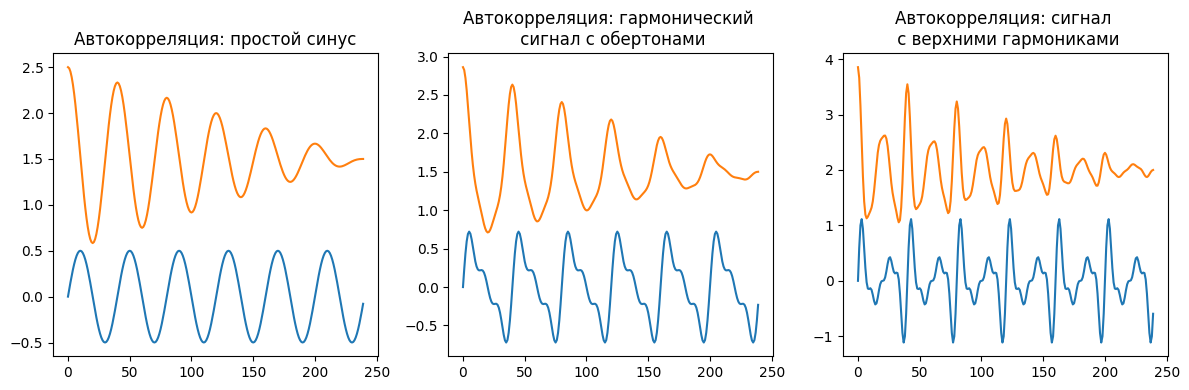

In [159]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(sine)
plt.plot(get_autocorr(sine) / 30 + 1.5)
plt.title('Автокорреляция: простой синус')

plt.subplot(1, 3, 2)
plt.plot(harmonic_signal)
plt.plot(get_autocorr(harmonic_signal) / 30 + 1.5)
plt.title('Автокорреляция: гармонический \n сигнал с обертонами')
plt.subplot(1, 3, 3)
plt.plot(missing_fundamental)
plt.plot(get_autocorr(missing_fundamental) / 30 + 2)
plt.title('Автокорреляция: сигнал \n с верхними гармониками')

plt.tight_layout()
plt.show()

In [160]:
def autocorrelation_f0(signal, fs, f0_min=50, f0_max=500):
    """
    Оценка f0 по первому пику автокорреляции после нулевой задержки.
    Возвращает период (в отсчётах) и соответствующую частоту.
    """
    corr = np.correlate(signal, signal, mode='full')
    corr = corr[len(corr)//2:]  # берём только правую половину

    # диапазон допустимых периодов
    min_lag = int(fs / f0_max)
    max_lag = int(fs / f0_min)

    # поиск пика в этом диапазоне
    relevant = corr[min_lag:max_lag+1]
    peak_idx = np.argmax(relevant) + min_lag

    if peak_idx > 0:
        period = peak_idx
        f0_est = fs / period
        return period, f0_est
    else:
        return None, 0

In [162]:
print("estimated f0: ", autocorrelation_f0(sine, fs)[1], "\n")
print("estimated f0: ", autocorrelation_f0(harmonic_signal, fs)[1], "\n")
print("estimated f0: ", autocorrelation_f0(missing_fundamental, fs)[1], "\n")

estimated f0:  200.0 

estimated f0:  200.0 

estimated f0:  200.0 



<h2>YIN</h2>
Alain de Cheveigné and Hideki Kawahara, "YIN, a fundamental frequency estimator for speech and music", J. Acoust. Soc. Am. 111, 1917 (2002); https://doi.org/10.1121/1.1458024

In [175]:
    def difference_function(x, max_period):
        """
        d_t(τ) = Σ(x_j - x_{j+τ})²
        
        Вместо автокорреляции используем разность
        """
        N = len(x)
        max_tau = min(max_period, N // 2)
        
        # Предвычисляем кумулятивную сумму для быстрого расчёта
        x_squared = x ** 2
        cumsum_x2 = np.cumsum(np.concatenate(([0], x_squared)))
        
        d = np.zeros(max_tau)
        
        # Для каждого возможного периода τ
        for tau in range(1, max_tau):
            # Разность между сигналом и его сдвинутой копией
            diff = x[:N-tau] - x[tau:]
            d[tau] = np.sum(diff ** 2)
            
        return d

In [176]:
    def cumulative_mean_normalized_difference(d):
        """
        Cumulative mean normalized difference function 
        d'_t(τ) = 1, если τ=0
                 = d_t(τ) / ((1/τ) * Σ d_t(j)), иначе
        
        (Для подавления субгармоник)
        """
        d_norm = np.zeros_like(d)
        d_norm[0] = 1
        
        # Кумулятивная сумма для нормализации
        cumsum = 0
        for tau in range(1, len(d)):
            cumsum += d[tau]
            if cumsum > 0:
                d_norm[tau] = d[tau] * tau / cumsum
            else:
                d_norm[tau] = 1
                
        return d_norm

In [177]:
def parabolic_interpolation(x, peak_idx):
        """
        Параболическая интерполяция для уточнения положения минимума
        """
        if peak_idx <= 0 or peak_idx >= len(x) - 1:
            return peak_idx, x[peak_idx]
        
        # Три точки вокруг минимума
        x0, x1, x2 = peak_idx - 1, peak_idx, peak_idx + 1
        y0, y1, y2 = x[x0], x[x1], x[x2]
        
        # Интерполяция параболой
        denom = (x0 - x1) * (x0 - x2) * (x1 - x2)
        if denom == 0:
            return peak_idx, y1
            
        A = (x2 * (y1 - y0) + x1 * (y0 - y2) + x0 * (y2 - y1)) / denom
        B = (x2**2 * (y0 - y1) + x1**2 * (y2 - y0) + x0**2 * (y1 - y2)) / denom
        
        if A == 0:
            return peak_idx, y1
            
        # Вершина параболы
        x_peak = -B / (2 * A)
        y_peak = A * x_peak**2 + B * x_peak + (y0 - A * x0**2 - B * x0)
        
        return x_peak, y_peak

In [178]:
def find_best_period(d_norm, min_period, threshold):
        """
        Поиск наилучшего периода с использованием порога
        """
        # Ищем первый минимум ниже порога
        for tau in range(min_period, len(d_norm)):
            if d_norm[tau] < threshold:
                # Проверяем, что это локальный минимум
                if tau > 0 and tau < len(d_norm) - 1:
                    if d_norm[tau] < d_norm[tau-1] and d_norm[tau] < d_norm[tau+1]:
                        # Интерполяция для уточнения
                        period, _ = parabolic_interpolation(d_norm, tau)
                        return period
        
        # Если ничего не нашли ниже порога, берём глобальный минимум
        global_min = np.argmin(d_norm[min_period:]) + min_period
        period, _ = parabolic_interpolation(d_norm, global_min)
        return period

In [179]:
def estimate_f0_yin(sig, fs, max_f0, min_f0, threshold):
        """
        Оценка f0 
        """

        max_period = int(fs / min_f0)
        min_period = int(fs / max_f0)

        # 1. Difference function
        d = difference_function(sig, max_period)
        
        # 2. Cumulative mean normalization
        d_norm = cumulative_mean_normalized_difference(d)
        
        # 3. Поиск наилучшего периода
        period = find_best_period(d_norm, min_period, threshold)
        
        if period > 0:
            f0 = fs / period
            # Confidence = 1 - значение функции в минимуме
            min_idx = int(np.round(period))
            if min_idx < len(d_norm):
                confidence = 1 - d_norm[min_idx]
            else:
                confidence = 0
        else:
            f0 = 0
            confidence = 0
            
        return f0, confidence, d_norm

In [169]:
min_f0 = 40
max_f0 = 500
threshold = 0.1

In [181]:
print("estimated f0: ", estimate_f0_yin(sine, fs, max_f0, min_f0, threshold)[0], "\n")
print("estimated f0: ", estimate_f0_yin(harmonic_signal, fs, max_f0, min_f0, threshold)[0], "\n")
print("estimated f0: ", estimate_f0_yin(missing_fundamental, fs, max_f0, min_f0, threshold)[0], "\n")

estimated f0:  200.03732405658835 

estimated f0:  200.05800038430326 

estimated f0:  199.96769745070677 



Задание. Построить график ЧОТ для реального гармонического сигнала разными методами (хотя бы YIN и автокорреляцией). Для этого нужно пройти по сигналу окнами и вычислить ЧОТ в каждом окне. Размер окна необходимо выбрать так, чтобы в одно окно входило несколько периодов ЧОТ.